# Simulating Thermal Behavior of Brake Discs During Braking Maneuvers

In [12]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Initial Setup and Parameters

In [13]:
# ----------------- VEHICLE DATA -----------------
M = 290.25                  # Car mass in kg
I = 0.1450                  # Moment of inertia of the rotating parts on the wheel [kg/m^2]
V_I = 70 / 3.6              # Initial vehicle speed [m/s]
V_F = 45 / 3.6              # Final vehicle speed [m/s]
V_MEAN = (V_F + V_I) / 2
R_WHEEL = 0.2032            # Wheel radius [m]
OMEGA_I = V_I / R_WHEEL     # Initial wheel angular speed [rad/s]
OMEGA_F = V_F / R_WHEEL     # Final wheel angular speed [rad/s]
DECEL_AVG = 0.5 * 9.81      # Average deceleration [m/s^2]
BRAKE_BIAS = 0.5            # Portion of the total braking load applied to the axle
T_STOP = (V_I - V_F) / DECEL_AVG  # Duration of the braking maneuver [s]
D_STOP = (V_I**2 - V_F**2) / (2 * DECEL_AVG)  # Distance covered during braking [m]
T_COOL = 5                  # Cooling time between braking maneuvers [s]
N_MATERIALS = 6             # Number of materials to compare
N = 100                     # Number of braking maneuvers to simulate
C_X = 1.12                  # Aerodynamic drag coefficient
S_CAR = 1                   # Front surface area of the car [m^2]

## Disk Data

In [14]:
# ----------------- FRONT DISC -----------------
R_DISC = .09319               # Disc outer radius [m]
V_DISC = .00007162            # Volume of the brake rotor [m^3]
A_TOTAL = 0.05                # Total surface area of the disc [m^2]

# ----------------- PAD PROPERTIES -----------------
H_PAD = 34 / 1000    # Pad height [m]
W_PAD = 0.04975      # Pad width [m]
S_P = H_PAD * W_PAD  # Pad friction area [m^2]
T_PAD = 4 / 1000     # Pad compound thickness [m]
T_PLATE = 3.5 / 1000 # Thickness of the backing plate [m]
S_D = .0127  # Disc friction area [m^2]

K_PAD = 12           # 1.31 # Thermal Conductivity of the pad [W/mK]
CP_PAD= 900          # 1230 # Specific Heat of the pad material [J/kgK]
RHO_PAD = 2500       # 2400  # Density [kg/m3]
K_PLATE= 15          # Thermal Conductivity of the backing plate[W/mK]
              #Assumed to be a low conductivity stainless steel alloy
              #This is a worst case, since it could be titanium.


## Air Props

In [15]:
# ----------------- AIR PROPERTIES -----------------
AIR_PROPS_DATA = np.array([
    [-150, 2.866, 983, 0.01171, 4.158e-06, 8.636e-06, 3.013e-06, 0.7246],
    [-100, 2.038, 966, 0.01582, 8.036e-06, 1.189e-06, 5.837e-06, 0.7263],
    [-50, 1.582, 999, 0.01979, 1.252e-05, 1.474e-05, 9.319e-06, 0.7440],
    [-40, 1.514, 1002, 0.02057, 1.356e-05, 1.527e-05, 1.008e-05, 0.7436],
    [-30, 1.451, 1004, 0.02134, 1.465e-05, 1.579e-05, 1.087e-05, 0.7425],
    [-20, 1.394, 1005, 0.02211, 1.578e-05, 1.630e-05, 1.169e-05, 0.7408],
    [-10, 1.341, 1006, 0.02288, 1.696e-05, 1.680e-05, 1.252e-05, 0.7387],
    [0, 1.292, 1006, 0.02364, 1.818e-05, 1.729e-05, 1.338e-05, 0.7362],
    [10, 1.246, 1006, 0.02439, 1.944e-05, 1.778e-05, 1.426e-05, 0.7336],
    [20, 1.204, 1007, 0.02514, 2.074e-05, 1.825e-05, 1.516e-05, 0.7309],
    [30, 1.164, 1007, 0.02588, 2.208e-05, 1.872e-05, 1.608e-05, 0.7282],
    [40, 1.127, 1007, 0.02662, 2.346e-05, 1.918e-05, 1.702e-05, 0.7255],
    [50, 1.092, 1007, 0.02735, 2.487e-05, 1.963e-05, 1.798e-05, 0.7228],
    [60, 1.059, 1007, 0.02808, 2.632e-05, 2.008e-05, 1.896e-05, 0.7202],
    [70, 1.028, 1007, 0.02881, 2.780e-05, 2.052e-05, 1.995e-05, 0.7177],
    [80, 0.9994, 1008, 0.02953, 2.931e-05, 2.096e-05, 2.097e-05, 0.7154],
    [90, 0.9718, 1008, 0.03024, 3.086e-05, 2.139e-05, 2.201e-05, 0.7132],
    [100, 0.9458, 1009, 0.03095, 3.243e-05, 2.181e-05, 2.306e-05, 0.7111],
    [120, 0.8977, 1011, 0.03235, 3.565e-05, 2.264e-05, 2.522e-05, 0.7073],
    [140, 0.8542, 1013, 0.03374, 3.898e-05, 2.345e-05, 2.745e-05, 0.7041],
    [160, 0.8148, 1016, 0.03511, 4.241e-05, 2.420e-05, 2.975e-05, 0.7014],
    [180, 0.7788, 1019, 0.03646, 4.593e-05, 2.504e-05, 3.212e-05, 0.6992],
    [200, 0.7459, 1023, 0.03779, 4.954e-05, 2.577e-05, 3.455e-05, 0.6974],
    [250, 0.6746, 1033, 0.04104, 5.890e-05, 2.760e-05, 4.091e-05, 0.6946],
    [300, 0.6158, 1044, 0.04418, 6.871e-05, 2.934e-05, 4.765e-05, 0.6935],
    [350, 0.5664, 1056, 0.04721, 7.892e-05, 3.101e-05, 5.475e-05, 0.6937],
    [400, 0.5243, 1069, 0.05015, 8.951e-05, 3.261e-05, 6.219e-05, 0.6948],
    [450, 0.488, 1081, 0.05298, 1.004e-04, 3.415e-05, 6.997e-05, 0.6965],
    [500, 0.4565, 1093, 0.05572, 1.117e-04, 3.563e-05, 7.806e-05, 0.6986],
    [600, 0.4042, 1115, 0.06093, 1.352e-04, 3.846e-05, 9.515e-05, 0.7037],
    [700, 0.3627, 1135, 0.06581, 1.598e-04, 4.111e-05, 1.133e-04, 0.7092],
    [800, 0.3289, 1153, 0.07037, 1.855e-04, 4.362e-05, 1.326e-04, 0.7149],
    [900, 0.3008, 1169, 0.07465, 2.122e-04, 4.600e-05, 1.529e-04, 0.7206],
    [1000, 0.2772, 1184, 0.07868, 2.398e-04, 4.826e-05, 1.741e-04, 0.7260],
    [1500, 0.199, 1234, 0.09599, 3.908e-04, 5.817e-05, 2.922e-04, 0.7478],
    [2000, 0.1553, 1264, 0.11113, 5.664e-04, 6.630e-05, 4.270e-04, 0.7539]
])

AIR_PROPS = {
    'Temp': AIR_PROPS_DATA[:, 0],           # Temperature [°K]
    'Density': AIR_PROPS_DATA[:, 1],        # Density [kg/m³]
    'Spec_Heat': AIR_PROPS_DATA[:, 2],      # Specific Heat [J/kgK]
    'Conductivity': AIR_PROPS_DATA[:, 3],   # Thermal Conductivity [W/mK]
    'Diffusivity': AIR_PROPS_DATA[:, 4],    # Thermal Diffusivity [m²/s]
    'Dyn_Visc': AIR_PROPS_DATA[:, 5],       # Dynamic Viscosity [kg/(m·s)]
    'Kin_Visc': AIR_PROPS_DATA[:, 6],       # Kinematic Viscosity [m²/s]
    'Prandtl': AIR_PROPS_DATA[:, 7]         # Prandtl Number 
}


AIR_PROPS.keys(), AIR_PROPS['Temp'][:5], AIR_PROPS['Density'][:5]

# Define interpolation functions for air properties
f_rho_air = interp1d(AIR_PROPS['Temp'], AIR_PROPS['Density'], kind='linear', fill_value="extrapolate")
f_Cp_air = interp1d(AIR_PROPS['Temp'], AIR_PROPS['Spec_Heat'], kind='linear', fill_value="extrapolate")
f_k_air = interp1d(AIR_PROPS['Temp'], AIR_PROPS['Conductivity'], kind='linear', fill_value="extrapolate")
f_mu_air = interp1d(AIR_PROPS['Temp'], AIR_PROPS['Dyn_Visc'], kind='linear', fill_value="extrapolate")

# Air properties interpolation functions (assuming AIR_PROPS data is loaded)
def get_air_properties(T):
    T_C = T - 273.15  # Convert to Celsius for interpolation
    rho_air = f_rho_air(T_C)
    mu_air = f_mu_air(T_C)
    Cp_air = f_Cp_air(T_C)
    k_air = f_k_air(T_C)
    return rho_air, mu_air, Cp_air, k_air

get_air_properties(20)

(array(4.574164), array(2.3999161e-05), array(1018.071), array(0.00323107))

## Mat Properties

In [16]:
# Function to calculate material properties based on temperature and material type
def material_properties(T_disc, mat):
    """
    Returns the material properties for a given disc temperature and material type.
    
    Parameters:
    T_disc (float): Temperature of the disc in Kelvin
    mat (int): Material type (1-6)

    Returns:
    rho_metal (float): Density [kg/m^3]
    k_metal (float): Thermal Conductivity [W/mK]
    Cp_metal (float): Specific Heat [J/kgK]
    K_PAD (float): Thermal Conductivity of the pad [W/mK]
    CP_PAD (float): Specific Heat of the pad [J/kgK]
    RHO_PAD (float): Density of the pad [kg/m^3]
    K_PLATE (float): Thermal Conductivity of the backing plate [W/mK]
    """

    # Convert temperature to Celsius for the calculation
    T = T_disc - 273.15

    # Material properties based on the given material type
    if mat == 1:
        # AISI 410 stainless-steel
        rho_metal = 7740  # Density [kg/m^3]
        if T < 100:
            k_metal = 24.9  # Thermal Conductivity [W/mK]
            Cp_metal = 460  # Specific Heat [J/kgK]
        else:
            k_metal = 0.0095 * T + 23.95  # Thermal Conductivity [W/mK]
            Cp_metal = 0.1 * T + 450  # Specific Heat [J/kgK]
    
    elif mat == 2:
        # AISI 4130 annealed steel     
        rho_metal = 7850  # Density [kg/m^3]
        k_metal =  36.32 # Thermal Conductivity [W/mK]
        Cp_metal = 600 # Specific Heat [J/kgK]

    else:
        raise ValueError("Invalid material type. Must be between 1 and 6.")

    # Pad properties (constant)
    K_PAD = 12  # Thermal Conductivity of the pad [W/mK]
    CP_PAD = 900  # Specific Heat of the pad material [J/kgK]
    RHO_PAD = 2500  # Density of the pad [kg/m^3]

    # Backing plate properties
    K_PLATE = 15  # Thermal Conductivity of the backing plate [W/mK]

    return rho_metal, k_metal, Cp_metal, K_PAD, CP_PAD, RHO_PAD, K_PLATE


### Average power dissipated during the single braking maneuver

$E_k =\frac{1}{2}{\mathrm{Bias}}_{\mathrm{front}\;} \left(\frac{1}{2}m\left(V_i^2 -V_{f\;}^2 \right)-\frac{1}{2}\rho {\;}_{\mathrm{air}\;} C_{x\;} {\mathrm{SV}}_{\mathrm{avg}}^2 d_{\mathrm{stop}} \right)+\frac{1}{2}I\left(\omega {\;}_i^2 -\omega {\;}_f^2 \right)$

Kinetic linear and rotational energies minus approximately the average energy dissipated by the aerodynamic drag.

In [17]:

Ef = 0.5 * BRAKE_BIAS * ((M / 2) * (V_I**2 - V_F**2) - 0.5 * 1.16 * C_X * S_CAR * ((V_I + V_F) / 2)**2 * D_STOP) + \
     (I / 2) * (OMEGA_I**2 - OMEGA_F**2)
Ef

7501.144307733262

In [18]:
P_avgF = Ef / T_STOP; #Average power dissipated during the braking maneuver [W]
P_avgF

5298.20824743816

# Simulation

In [19]:
# Number of time steps (assuming 'N' is defined)
n_time_steps = 2 * N

# Initialize arrays
T_disc = np.zeros(n_time_steps)
T_film = 0
h_conv = 0
rho_air_f = 0
mu_air_f = 0
Cp_air_f = 0
k_air_f = 0
Re_f = 0
Pr_f = 0
BixFo = 0

# Initialize results matrix
T_disc_mat = np.zeros((N_MATERIALS, n_time_steps))

In [22]:
for mat in range(N_MATERIALS):
    # Initialize disc temperature for this material
    T_disc = np.zeros(n_time_steps)
    T_disc[0] = 60 + 273.15  # Initial disc temperature [K]
    T_air = 22 + 273.15      # Air temperature [K]
    
    # Load initial material properties
    rho_metal, k_metal, Cp_metal, K_PAD, CP_PAD, RHO_PAD, K_PLATE = material_properties(T_disc[0], 2)
    
    # Initialize variables
    Dt_cool = 0
    DT_f = 0
    
    # 100 braking maneuvers
    for i in range(n_time_steps):
        if i == 0:
            T_film = (T_air + T_disc[i]) / 2
            continue
        elif i > 0 and (i % 2) == 1:
            # **Cooling Phase**
            T_disc[i] = T_disc[i - 1] - Dt_cool
            # Update film temperature after cooling
            T_film = (T_air + T_disc[i]) / 2
        elif (i % 2) == 0:
            # **Braking Phase**
            # Calculate BixFo using the previous time step's h_conv
            BixFo = h_conv * A_TOTAL * T_COOL / (rho_metal * V_DISC * Cp_metal)
            
            # Update disc temperature using the energy balance
            exponent = -0.5 * (i + 1) * BixFo  # (i +1) to account for 0-indexing
            denominator = 1 - np.exp(-BixFo)
            if denominator == 0:
                raise ZeroDivisionError("Denominator in temperature calculation is zero.")
            T_disc[i] = T_air + (1 - np.exp(exponent)) * DT_f / denominator
            
            # Update film temperature after braking
            T_film = (T_air + T_disc[i]) / 2
        
        # Update air properties at film temperature
        rho_air_f, mu_air_f, Cp_air_f, k_air_f = get_air_properties(T_film)
        
        # Reynolds number
        Re_f = (V_MEAN * 2 * R_DISC * rho_air_f) / mu_air_f
        
        # Prandtl number
        Pr_f = (mu_air_f * Cp_air_f) / k_air_f
        
        # Heat transfer coefficient
        h_conv = 0.04 * (k_air_f / (2 * R_DISC)) * Re_f ** 0.8
        
        if (i % 2) == 0:
            # **Braking Phase**: Update material properties and perform heat transfer calculations
            # Load material properties at current temperature
            rho_metal, k_metal, Cp_metal, K_PAD, CP_PAD, RHO_PAD, K_PLATE = material_properties(T_disc[i], 2)
            
            # Biot number verification
            Bi = h_conv * (V_DISC / A_TOTAL) / k_metal
            if Bi > 0.1:
                raise ValueError("Biot number exceeds 0.1, invalid lumped capacitance assumption")
            
            # Thermal resistance calculations
            Rd = 1 / (A_TOTAL * h_conv)  # Thermal resistance of the brake rotor
            hp_conv = h_conv  # Heat convection coefficient of the pad
            Rp = (1 / hp_conv) + (T_PAD / (K_PAD * S_P)) + (T_PLATE / (K_PLATE * S_P))  # Thermal resistance of the pad
            p = 1 / (1 + Rd / Rp)  # Heat partition coefficient
            
            # Heat dissipated by convection and radiation
            H_convection = h_conv * A_TOTAL * (T_disc[i] - T_air)
            H_radiation = 5.670367e-8 * A_TOTAL * 2 * ((T_disc[i] ** 4) - (T_air ** 4))
            
            # Cooling factor
            f = (S_D - (2 * S_P)) / S_D  # Approximately 0.8
            
            # Compute cooling
            Dt_cool = (-H_convection - H_radiation) * T_COOL / (rho_metal * V_DISC * Cp_metal)
            
            # Compute temperature rise
            Dt_brake = P_avgF * T_STOP * p / (rho_metal * V_DISC * Cp_metal)
            DT_f = Dt_brake + Dt_cool * f
    
    # Save the results from the current material cycle
    T_disc_mat[mat, :] = T_disc


In [10]:
h_conv

83.28687027690772

## Visualize Data

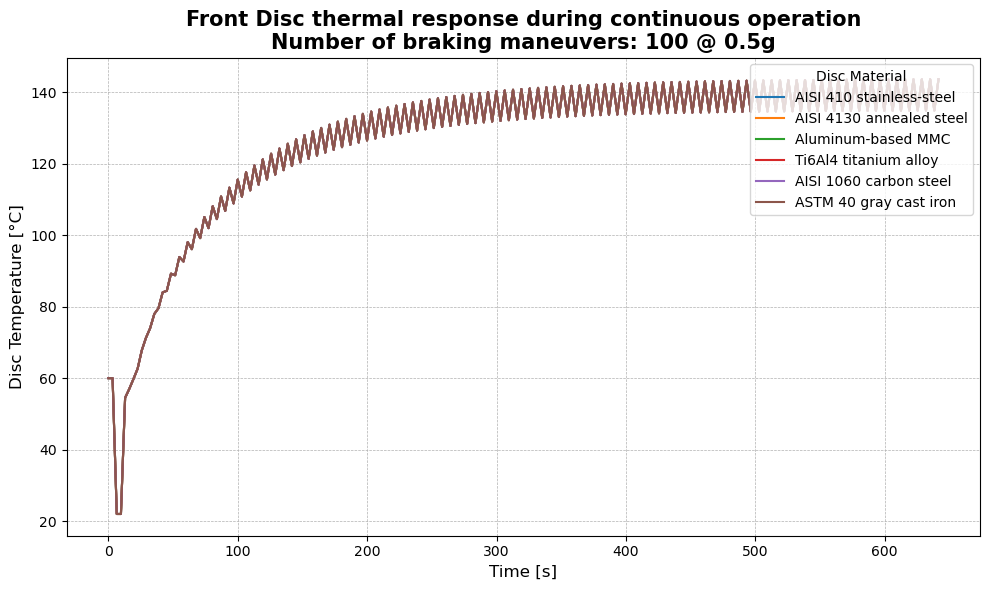

In [23]:
time = np.linspace(0, (T_STOP + T_COOL) * N, 2 * N)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot each material's temperature curve
for i, material in enumerate(['AISI 410 stainless-steel', 'AISI 4130 annealed steel',
                              'Aluminum-based MMC', 'Ti6Al4 titanium alloy',
                              'AISI 1060 carbon steel', 'ASTM 40 gray cast iron']):
    plt.plot(time, T_disc_mat[i] - 273.15, label=material)

# Formatting
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Disc Temperature [°C]', fontsize=12)

# Title and subtitle
plottitle = 'Front Disc thermal response during continuous operation'
subtitle = f'Number of braking maneuvers: {N} @ {DECEL_AVG/9.81:.1f}g'
plt.title(f'{plottitle}\n{subtitle}', fontsize=15, fontweight='bold', color='black')

# Legend
plt.legend(title='Disc Material', loc='upper right', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()